In [2]:

import numpy as np
import json
import os

import cv2
import mediapy as media

import mujoco
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import importlib
import util

# Preparation

In [3]:
json_vars = util.load_json_variables()

""

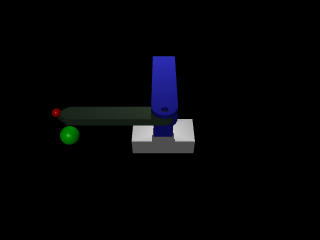

In [4]:
xml_path = "2dof_robot.xml"

# Read the XML content from the file
with open(xml_path, 'r') as file:
    my_robot_xml = file.read()
model = mujoco.MjModel.from_xml_string(my_robot_xml)
data = mujoco.MjData(model)
height = 480
width = 640


with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

## Let's try testing randomizing ball position

179.63554396909643 5.39320092946092 113.06695247011977 -139.58793972329002
Original ball position: [-100. -120.  150.]
New ball position: [np.float64(113.06695247011977), np.float64(-139.58793972329002)]


""

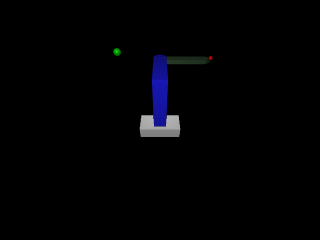

In [5]:

import util

importlib.reload(util)

# Read the XML content from the file
with open(xml_path, 'r') as file:
    my_robot_xml = file.read()
model = mujoco.MjModel.from_xml_string(my_robot_xml)
util.randomize_ball_position(model, json_vars, seed=None, print_info=True)
data = mujoco.MjData(model)
height = 480
width = 640


with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, camera='my_camera')
  media.show_image(renderer.render())

# Use dummy policy

In [ ]:
import robot_env
import training_module

importlib.reload(robot_env)
importlib.reload(training_module)
importlib.reload(util)


# Define a dummy policy that always outputs the same action value
class DummyPolicy:
    def __init__(self, action_value):
        self.action_value = action_value

    def predict(self, obs):
        return self.action_value, None

dummy_policy = DummyPolicy(action_value=np.array([1, 0]))
env = robot_env.ArmEnv(model_path='2dof_robot.xml')
obs, _ = env.reset()

frames = []
# Simulate for a few seconds
for _ in range(100):
    action, _ = dummy_policy.predict(obs)
    obs, reward, done, truncated, info = env.step(action)
    frame = env.render(mode='rgb_array')
    text_list = [
                f'Step: {info["current_step"]}',
                f'Action: {action[0]:.2f} {action[1]:.2f}',
                f'distance: {info["distance"]:.4f}',
                f'qvel: {info["qvel"][0]:.2f} {info["qvel"][1]:.2f}',
                f'Arm Tip XYZ: {info["arm2_tip_pos"][0]:.2f} {info["arm2_tip_pos"][1]:.2f} {info["arm2_tip_pos"][2]:.2f}',
                f'Ball XYZ: {info["ball_pos"][0]:.2f} {info["ball_pos"][1]:.2f} {info["ball_pos"][2]:.2f}',
                f'done: {done}',
                f'reward: {reward:.2f}',
                f'is_success: {info["is_success"]}'
                ]
    frames.append(util.add_text_frame(text_list, frame))
    # print(f"Step: {info['current_step']}, Action: {action}, Reward: {reward}, Done: {done}")
    
    if done:
        break

env.close()


In [ ]:
# media.show_video(frames, fps=30)

# Using RL to learn policy

In [15]:
import robot_env
import training_module

importlib.reload(robot_env)
importlib.reload(training_module)
importlib.reload(util)

# Create the custom environment
env = robot_env.ArmEnv(model_path='2dof_robot.xml')

# Check the environment
check_env(env)

load_existing_model = False

learning_rate = 1e-3

if load_existing_model:
    print("Loading existing model")
    rl_model = PPO.load("best_model.zip", env=env)
    rl_model.learning_rate = training_module.linear_schedule(learning_rate)
else:
    print('Creating new model')
    rl_model = PPO(
        "MlpPolicy", 
        env, 
        verbose=1, 
        tensorboard_log="./ppo_logs/",
        learning_rate=training_module.linear_schedule(learning_rate),
        gamma=0.999,
        policy_kwargs=dict(net_arch=[8, 8]),
        n_steps=2**8,  # Collect more steps before updating policy
        # batch_size=64,  # Mini-batch size for training
        # n_epochs=10,  # More training passes per batch
        # ,  # Discount factor
        # gae_lambda=0.95,  # Smoother advantage estimation
        # clip_range=0.2,  # Clipping parameter
        # ent_coef=0.01,  # Encourages exploration
        # vf_coef=0.5,  # Importance of value function loss
        # max_grad_norm=0.5,  # Prevents exploding gradients
        
    )

reward_logger = training_module.RewardLoggerCallback(env, movie_save_freq=int(5e5), model_save_freq=int(5e5), verbose=1)

# Train the agent
rl_model.learn(total_timesteps=int(10e6), callback=reward_logger, tb_log_name="PPO")



Creating new model
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_logs/PPO_13


-----------------------------
| time/              |      |
|    fps             | 1171 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 256  |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1026         |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 512          |
| train/                  |              |
|    approx_kl            | 0.0022363137 |
|    clip_fraction        | 0.00195      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -6.81e-05    |
|    learning_rate        | 0.001        |
|    loss                 | 1.17e+05     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00363     |
|    std                  | 1.01         |
|    value_loss           | 2.36e+05     |
----------------

KeyboardInterrupt: 